# Deloitte Quantum Challenge 2023

In [ ]:
'''
Team: Quantux
Members: ...

V00 20230317 - Establishment
'''

In [ ]:
'''
References:
https://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious/blob/main/Chapter_05_Variational_Quantum_Eigensolver_.VQE._algorithm_V2.ipynb
https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk
https://qiskit.org/documentation/nature/_modules/qiskit_nature/second_q/
https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html

https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1
'''

# Import libraries and functions

In [7]:
import pandas as pd
import numpy as np
import warnings, os, time
warnings.filterwarnings('ignore')

from functools import wraps

In [6]:
# Timeit decorator
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper


In [2]:
!pip install qiskit-nature

     ---------------------------------------- 3.8/3.8 MB 34.7 MB/s eta 0:00:00


In [8]:

# Molecule definition
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit

# Driver & ansatz libraries
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD

# Algorithms, mappers & optimizers
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, BravyiKitaevMapper, ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer

from qiskit_nature.second_q.algorithms import NumPyMinimumEigensolverFactory, VQEUCCFactory
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA


# Estimators & Samplers
from qiskit.primitives import Estimator, Sampler

'''
from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation
from qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution

'''

'\nfrom qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation\nfrom qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution\n\n'

In [9]:
def get_construct_problem(molecule, reduced = 'ActiveSpace', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', display_report = False):
    
    # 0. Display Report Dict
    if display_report:
        display_dict = {}
        
    
    # 1. Define Molecule dictionary
    # =============================
    moleculeinfo = MoleculeInfo(symbols = molecule['symbols'], coords = molecule['coords'], charge = molecule['charge'], multiplicity = molecule['multiplicity'])
    driver = PySCFDriver.from_molecule(moleculeinfo, basis=basis)
    problem = driver.run()
    
    # 2. Initialise Fermion to qubit mappers
    # =============================
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
    
    
    # 3. Transform Problem to reduce simulation space
    # =============================
    # FreezeCoreTransformer will remove the single lowest energy orbital (reducing the total number of spatial orbitals by 1)
    # and also removing the two electrons from within that orbital.
    # ActiveSpaceTransformer is a Hilbert Space reduction to FreezeCoreTransformer, by selecting the number of active electrons and the number of active spatial orbitals.
    if reduced == 'FreezeCore':
        pass
        # fc_transformer = FreezeCoreTransformer(freeze_core = True, remove_orbitals=hyperparam['fc_remove_orbitals'])
        # problem = fc_transformer.transform(problem)
        # How to determine which orbitas to be removed
        # https://quantumcomputing.stackexchange.com/questions/17852/use-one-body-integrals-to-know-which-orbitals-to-freeze-in-electronicstructurepr
        # https://www.youtube.com/watch?v=3B04KB0pDwE&t=667s
        
    elif reduced == 'ActiveSpace':
        #max_num_spatial_orbitals = problem.num_spatial_orbitals
        #max_num_electrons = problem.num_electrons
        #max_active_orbitals = itertools.combinations(max_num_spatial_orbitals, 2)
        # Use optuna to setup objective
        
        as_transformer = ActiveSpaceTransformer(num_electrons=hyperparam['as_num_electrons'], 
                                                num_spatial_orbitals=hyperparam['as_num_spatial_orbitals'], 
                                                active_orbitals=hyperparam['as_active_orbitals'])
        problem = as_transformer.transform(problem)
    
    
    # 4. Generate converter objects after pass through transformers
    # =============================
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
        
    qubit_converter = QubitConverter(mapper, 
                                     two_qubit_reduction=hyperparam['two_qubit_reduction'], 
                                     z2symmetry_reduction=hyperparam['z2symmetry_reduction'])
    qubit_op = qubit_converter.convert(second_q_op, num_particles=num_particles)
    
    if display_report:
        # Use 'k: v' for k,v in display_dict.items() to display
        display_dict['num_spin_orbitals'] = num_spin_orbitals
        display_dict['num_spatial_orbitals'] = problem.num_spatial_orbitals
        display_dict['num_particles'] = num_particles
        display_dict['nuclear_repulsion_energy'] = problem.nuclear_repulsion_energy
        display_dict['num_alpha'] = problem.num_alpha
        display_dict['num_beta'] = problem.num_beta
        display_dict['second_q_op'] = "\n".join(str(second_q_op).splitlines()[:10] + ["..."])
    
    
    # 5. Define solvers
    # =============================
    tl_circuit = TwoLocal(rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', entanglement='full', reps=hyperparam['tl_reps'], parameter_prefix = 'y')
    
    if solver_type == 'numpy_solver_with_filter':
        solver = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)
        
    elif solver_type == 'numpy_solver':
        solver = NumPyMinimumEigensolverFactory()
    
    elif solver_type == 'vqe_twolocal':
        estimator = Estimator()
        optimizer = SPSA(maxiter=100)
        
        solver = VQE(estimator, tl_circuit, optimizer)
    
    elif solver_type == 'vqe_ucc_solver':
        estimator = Estimator()
        initial_circuit = UCCSD()
        optimizer = SLSQP()
        
        solver = VQEUCCFactory(estimator, initial_circuit, optimizer)
    
    elif solver_type == 'vqe_qnpsa':
        
        qnspsa_loss = []
        def qnspsa_callback(nfev, x, fx, stepsize, accepted):
            qnspsa_loss.append(fx)
            
        ansatz = tl_circuit
        sampler = Sampler()
        fidelity = QNSPSA.get_fidelity(ansatz, sampler)
        qnspsa = QNSPSA(fidelity, maxiter=200, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)
        
        solver = VQE(estimator, tl_circuit, optimizer=qnspsa)
        
    
    if display_report:
        display_dict['solver'] = 'Solver selected: {}'.format(solver_type)
        
    # Plot has 3 lines, GSES, RHF, VQE
    # 6. Solution method (Restricted Hartree-Fock, GroundStateEigenSolver, QuantumPhaseEstimation, Pertubation BOPES
    # =============================
    if method == 'gses':
        calc = GroundStateEigensolver(qubit_converter, solver)
        ground_state = calc.solve(problem)
        
    elif method == 'qpe':
        # Quantum Phase Estimation
        pass
    

    if display_report:
        display_dict['solution_method'] = method
    
    
    # Z. Display Final Report
    # =============================
    if display_report:
        print(['{}: {}\n'.format(k, v) for k, v in display_dict.items()])
    
    return fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state


In [10]:
# return fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state


def get_bopes(moleculeinfo, qubit_converter, hyperparam, mapper_type, solver_type, perturbation_steps = np.linspace(-3, 3, 25)):
    
    EPSILON = 1e-3
    
    atom_pair = moleculeinfo['atom_pair']
    x0, y0, z0 = moleculeinfo['coords'][moleculeinfo['atom_pair'][0] - 1]
    x1, y1, z1 = moleculeinfo['coords'][moleculeinfo['atom_pair'][1] - 1]
    
    # Get a straight line connecting the 2 interacting atom pair, y = mx + p
    m = 0
    p = y0
    if abs(x1 - x0) > EPSILON:
        m = (y1 - y0)/(x1 - x0)
        p = y0 - m*x0
    
    # This perturbation assumes lying on the same plane
    size = len(perturbation_steps)
    energy_lst = np.empty(size)
    
    for k in range(size):
        print("Step: ", k)
        
        if (abs(x0) < EPSILON and abs(y0) < EPSILON):
            z0_new = z0 + perturbation_steps[k]
            
            coords_new = []
            for l in range(len(moleculeinfo['coords'])):
                if l == atom_pair[0]:
                    coords_new.append((0.0, 0.0, z0_new))
                else:
                    coords_new.append(moleculeinfo['coords'][l])
        
        elif (abs(z0) < EPSILON and abs(z1) < EPSILON):
            x0_new = x0 + perturbation_steps[k]
            y0_new = m*x0_new + p
            
            coords_new = []
            for l in range(len(moleculeinfo['coords'])):
                if l == atom_pair[0]:
                    coords_new.append((x0_new, y0_new, 0.0))
                else:
                    coords_new.append(moleculeinfo['coords'][l])
                    
        else:
            print("bopes - Error: unsupported molecule geometry, atom pairs must be in the same line or in the same plane")
            return perturbation_steps, 0
    
        moleculeinfo_new = moleculeinfo.copy()
        moleculeinfo_new['coords'] = coords_new
        
        fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state = get_construct_problem(moleculeinfo_new, 
                                                                                                                                 reduced = 'ActiveSpace', 
                                                                                                                                 basis = 'sto3g', 
                                                                                                                                 mapper_type = 'JordanWignerMapper', 
                                                                                                                                 solver_type = 'numpy_solver', 
                                                                                                                                 method = 'gses', 
                                                                                                                                 display_report = False)

    
        energy_lst[k] = ground_state.total_energies
        return perturbation_steps, energy_lst


In [11]:
molecule_c3 = {
    'symbols': ["O","N","C","H","H","H","C"],
    'coords': [(1.1280, 0.2091, 0.0000), 
                (-1.1878, 0.1791, 0.0000),
                (0.0598, -0.3882, 0.0000),
                (-1.3085, 1.1864, 0.0001),
                (-2.0305, -0.3861, -0.0001),
                (-0.0014, -1.4883, -0.0001),
                (-0.1805, 1.3955, 0.0000)],
    'multiplicity': 1,
    'charge': 0,
    'units': DistanceUnit.ANGSTROM,
    'masses': [8, 7, 6, 1, 1, 1, 6],
    'atom_pair': (6, 1)

}

hyperparam = {
    #'fc_remove_orbitals': [4, 5],
    'fc_remove_orbitals': None,
    'as_num_electrons': 2,
    'as_num_spatial_orbitals': 2,
    'as_active_orbitals': None,
    'tl_reps': 2,
    'two_qubit_reduction': True,
    'z2symmetry_reduction': 'auto',
    'perturbation_steps': np.linspace(-0.5, 3, 25)

}


In [12]:
fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state = get_construct_problem(molecule = molecule_c3, 
                                                                                                                         reduced = 'ActiveSpace', 
                                                                                                                         basis = 'sto3g', 
                                                                                                                         mapper_type = 'JordanWignerMapper', 
                                                                                                                         solver_type = 'numpy_solver', 
                                                                                                                         method = 'gses', 
                                                                                                                         display_report = False)
step, energy = get_bopes(molecule_c3, qubit_converter, hyperparam, mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', perturbation_steps = np.linspace(-0.5, 2, 25))

MissingOptionalLibraryError: "The 'pyscf' library is required to use 'PySCFDriver'.  See https://pyscf.org/install.html."

In [45]:
def plot_energy_landscape(step, energy):
    if len(step) > 1:
        plt.plot(step, energy, label="VQE Energy")
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        # print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    return

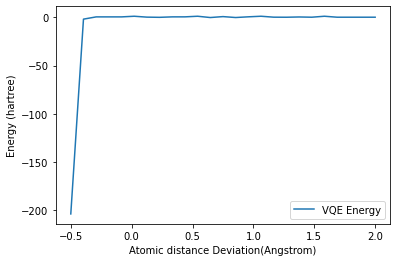

In [46]:
plot_energy_landscape(step, energy)

In [95]:
#lst_mapper_type = ['ParityMapper', 'JordanWignerMapper', 'BravyiKitaevMapper']
lst_mapper_type = ['JordanWignerMapper']
#lst_reduced = ['FreezeCore', 'ActiveSpace'] # FreezeCore needs expert judgment on orbital removals
lst_reduced = ['ActiveSpace']
lst_solver_type = ['numpy_solver_with_filter', 'numpy_solver', 'vqe_twolocal', 'vqe_ucc_solver', 'vqe_qnpsa']
lst_method = ['gses', 'qpe', 'rhf_pyqmc', 'rhf']

test_dict = {}
for a in lst_mapper_type:
    for b in lst_reduced:
        for c in lst_solver_type:
            for d in lst_method:
                try:
                    print('Now running: {}|{}|{}|{}'.format(a, b, c, d))
                    fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state = get_construct_problem(molecule = molecule_c3, 
                                                                                                                             reduced = b, 
                                                                                                                             basis = 'sto3g', 
                                                                                                                             mapper_type = a, 
                                                                                                                             solver_type = c, 
                                                                                                                             method = d, 
                                                                                                                             display_report = False)
                    test_dict['{}|{}|{}|{}'.format(a, b, c, d)] = ground_state
                except:
                    test_dict['{}|{}|{}|{}'.format(a, b, c, d)] = 'Error'

test_dict

Now running: JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|gses
Now running: JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|qpe
Now running: JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf_pyqmc
Now running: JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf
Now running: JordanWignerMapper|ActiveSpace|numpy_solver|gses
Now running: JordanWignerMapper|ActiveSpace|numpy_solver|qpe
Now running: JordanWignerMapper|ActiveSpace|numpy_solver|rhf_pyqmc
Now running: JordanWignerMapper|ActiveSpace|numpy_solver|rhf
Now running: JordanWignerMapper|ActiveSpace|vqe_twolocal|gses
Now running: JordanWignerMapper|ActiveSpace|vqe_twolocal|qpe
Now running: JordanWignerMapper|ActiveSpace|vqe_twolocal|rhf_pyqmc
Now running: JordanWignerMapper|ActiveSpace|vqe_twolocal|rhf
Now running: JordanWignerMapper|ActiveSpace|vqe_ucc_solver|gses
Now running: JordanWignerMapper|ActiveSpace|vqe_ucc_solver|qpe
Now running: JordanWignerMapper|ActiveSpace|vqe_ucc_solver|rhf_pyqmc
Now

{'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf65184c40>,
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf_pyqmc': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf64ec6070>,
 'JordanWignerMapper|ActiveSpace|numpy_solver|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|rhf_pyqmc': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|rhf': 'Error',
 'JordanWignerMapper|ActiveSpace|vqe_twolocal|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf65347850>,
 'JordanWignerMapper|ActiveSpace|vqe_twolocal|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|

In [96]:
test_dict

{'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf65184c40>,
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf_pyqmc': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver_with_filter|rhf': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf64ec6070>,
 'JordanWignerMapper|ActiveSpace|numpy_solver|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|rhf_pyqmc': 'Error',
 'JordanWignerMapper|ActiveSpace|numpy_solver|rhf': 'Error',
 'JordanWignerMapper|ActiveSpace|vqe_twolocal|gses': <qiskit_nature.second_q.problems.electronic_structure_result.ElectronicStructureResult at 0x7fdf65347850>,
 'JordanWignerMapper|ActiveSpace|vqe_twolocal|qpe': 'Error',
 'JordanWignerMapper|ActiveSpace|

In [ ]:

molecule_h2o = {
    'symbols': ['O', 'H', 'H'],
    'coords': [(0.0, 0.0, 0.0), (0.758602, 0.0, 0.504284), (0.758602, 0.0, -0.504284)],
    'multiplicity': 1,
    'charge': 0,
    'units': DistanceUnit.ANGSTROM,
    'masses': [15.999, 1.00784, 1.00784],
    'atom_pair': (1, 0)
}

fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state = get_construct_problem(molecule = molecule_h2o, 
                                                                                                                         reduced = 'ActiveSpace', 
                                                                                                                         basis = 'sto3g', 
                                                                                                                         mapper_type = 'ParityMapper', 
                                                                                                                         solver_type = 'numpy_solver', 
                                                                                                                         method = 'gses', 
                                                                                                                         display_report = False)

hyperparam = {
    'fc_remove_orbitals': [4, 5],
    'as_num_electrons': 0,
    'as_num_spatial_orbitals': 0,
    'as_active_orbitals': None,
    'tl_reps': 2,
    'two_qubit_reduction': True,
    'z2symmetry_reduction': 'auto',
}